In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Victor Hugo
### Les Miserables

In [2]:
BODY_START = 684
BODY_END = 67303
CHAP_PAT = r'^\s*(?:VOLUME|BOOK|CHAPTER).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/Les_Misérables.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['BOOK FIRST--A JUST MAN\n',
 '\n',
 '\n',
 '\n',
 'CHAPTER I--M. MYRIEL\n',
 '\n',
 'In 1815, M. Charles-François-Bienvenu Myriel was Bishop of D---- He was\n',
 'an old man of about seventy-five years of age; he had occupied the see\n',
 'of D---- since 1806.\n',
 '\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,BOOK FIRST--A JUST MAN\n
1,\n
2,\n
3,\n
4,CHAPTER I--M. MYRIEL\n


In [8]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/crystal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/crystal/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/crystal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [54]:
cfg = dict(
    src_file = src_file,
    body_start = 684,
    body_end = 67303,
    chap_pat = r'^\s*(?:VOLUME|BOOK|CHAPTER).*$'
)
LM_K, LM_V = text_to_tokens(**cfg)

In [55]:
LM_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NNP      BOOK     0    0     book   
                           1          NNP     FIRST     0    0    first   
                           2            :         -     1    0      NaN   
                           3            :         -     1    0      NaN   
                           4           DT         A     0    0        a   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2475  
                           1             8287  
                           2               -1  
                           3               -1  
                           4              131

In [56]:
LM_K = LM_K.loc[LM_K.term_id >= 0]

In [57]:
LM_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NNP      BOOK     0    0     book   
                           1          NNP     FIRST     0    0    first   
                           4           DT         A     0    0        a   
                           5          NNP      JUST     0    0     just   
                           6           NN       MAN     0    0      man   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2475  
                           1             8287  
                           4              131  
                           5            11560  
                           6            12703

In [58]:
LM_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,'abjure,1,0.000002,'abjur,0
1,'ah,5,0.000009,'ah,0
2,'all,2,0.000004,'all,0
3,'and,1,0.000002,'and,0
4,'answer,1,0.000002,'answer,0


In [59]:
WORDS = (LM_K.punc == 0) & (LM_K.num == 0) & LM_K.term_id.isin(LM_V[LM_V.stop==0].index)

In [60]:
BOW = LM_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [61]:
DTM = BOW.unstack().fillna(0)

In [62]:
DTM.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
alpha = .000001
alpha_sum = alpha * LM_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [64]:
N_docs = DTM.shape[0]
LM_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / LM_V[LM_V.stop==0]['df'])

In [65]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.879280e-06,2.111179e-06,2.548477e-06,2.879280e-06,2.879280e-06,2.879280e-06,2.548477e-06,2.879280e-06,2.879280e-06,2.879280e-06,...,2.548477e-06,2.354970e-06,2.879280e-06,2.879280e-06,2.879280e-06,2.879280e-06,2.879280e-06,2.879280e-06,2.548477e-06,2.879280e-06
1,1.787165e-08,1.310406e-08,1.581836e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.581836e-08,1.787165e-08,1.787165e-08,1.787165e-08,...,1.581836e-08,1.461726e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.581836e-08,1.787165e-08
2,1.016784e-08,7.455379e-09,8.999646e-09,1.016784e-08,1.016784e-08,1.016784e-08,8.999646e-09,1.016784e-08,1.016784e-08,1.016784e-08,...,8.999646e-09,8.316297e-09,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,8.999646e-09,1.016784e-08
3,2.417597e-08,1.772658e-08,2.139837e-08,2.417597e-08,2.417597e-08,2.417597e-08,2.139837e-08,2.417597e-08,2.417597e-08,2.417597e-08,...,2.139837e-08,1.977358e-08,2.417597e-08,2.417597e-08,2.417597e-08,2.417597e-08,2.417597e-08,2.417597e-08,2.139837e-08,2.417597e-08
4,6.413969e-09,4.702924e-09,5.677062e-09,6.413969e-09,6.413969e-09,6.413969e-09,5.677062e-09,6.413969e-09,6.413969e-09,6.413969e-09,...,5.677062e-09,5.245999e-09,6.413969e-09,6.413969e-09,6.413969e-09,6.413969e-09,6.413969e-09,6.413969e-09,5.677062e-09,6.413969e-09


In [66]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [67]:
TFTH.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.798433e-09,2.306220e-08,4.468004e-09,3.580329e-09,2.739645e-09,2.543546e-09,6.978918e-09,1.062870e-09,1.006774e-09,4.958332e-09,...,1.836420e-08,2.534071e-08,4.832123e-09,4.832123e-09,3.555119e-09,3.121696e-09,1.984593e-09,4.057590e-09,4.033189e-09,4.523961e-09
1,1.116285e-11,1.431467e-10,2.773283e-11,2.222305e-11,1.700493e-11,1.578775e-11,4.331804e-11,6.597217e-12,6.249030e-12,3.077629e-11,...,1.139863e-10,1.572894e-10,2.999291e-11,2.999291e-11,2.206657e-11,1.937632e-11,1.231834e-11,2.518540e-11,2.503394e-11,2.808016e-11
2,6.350953e-12,8.144145e-11,1.577823e-11,1.264351e-11,9.674732e-12,8.982234e-12,2.464522e-11,3.753400e-12,3.555303e-12,1.750977e-11,...,6.485100e-11,8.948772e-11,1.706407e-11,1.706407e-11,1.255448e-11,1.102390e-11,7.008357e-12,1.432890e-11,1.424273e-11,1.597584e-11
3,1.510060e-11,1.936425e-10,3.751574e-11,3.006235e-11,2.300351e-11,2.135697e-11,5.859870e-11,8.924421e-12,8.453409e-12,4.163279e-11,...,1.541956e-10,2.127740e-10,4.057307e-11,4.057307e-11,2.985067e-11,2.621142e-11,1.666370e-11,3.406968e-11,3.386480e-11,3.798558e-11
4,4.006242e-12,5.137404e-11,9.953056e-12,7.975646e-12,6.102912e-12,5.666078e-12,1.554644e-11,2.367680e-12,2.242719e-12,1.104533e-11,...,4.090863e-11,5.644970e-11,1.076418e-11,1.076418e-11,7.919488e-12,6.953981e-12,4.420938e-12,9.038805e-12,8.984449e-12,1.007771e-11


In [68]:
LM_V['tf_sum'] = TF.sum()
LM_V['tf_mean'] = TF.mean()
LM_V['tf_max'] = TF.max()
LM_V['tfidf_sum'] = TFIDF.sum()
LM_V['tfidf_mean'] = TFIDF.mean()
LM_V['tfidf_max'] = TFIDF.max()
LM_V['tfth_sum'] = TFTH.sum()
LM_V['tfth_mean'] = TFTH.mean()
LM_V['tfth_max'] = TFTH.max()
LM_V['th_sum'] = THM.sum()
LM_V['th_mean'] = THM.mean()
LM_V['th_max'] = THM.max()

In [69]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = LM_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [70]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,book,enlarge,book,twelfth,book,book,one,enlarge
1,one,supreme,enlarge,parenthesis,one,man,book,supreme
2,man,tenth,seventh,tenth,man,first,'s,tenth
3,'s,first,sixth,leviathan,'s,cosette,man,first
4,said,seventh,eighth,excellence,said,little,said,seventh
5,marius,parenthesis,fifth,derailed,marius,two,two,parenthesis
6,first,éponine,marius,ninth,two,marius,marius,éponine
7,enlarge,twelfth,fourth,desolations,jean,'s,jean,twelfth
8,jean,sixth,volume,intestine,first,one,little,sixth
9,two,waterloo,javert,enchantments,little,jean,would,waterloo


In [71]:
LM_V = LM_V[LM_V['stop'] == 0]

In [72]:
LM_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
0,'abjure,1,0.000002,'abjur,0,1.0,0.000478,0.000001,0.000465,0.004160,0.000010,0.004048,0.000003,6.231600e-09,0.000003,0.005437,0.000013,0.005149
1,'ah,5,0.000009,'ah,0,5.0,0.007886,0.000019,0.004166,0.050327,0.000121,0.026589,0.000550,1.318374e-06,0.000290,0.069716,0.000167,0.032943
2,'all,2,0.000004,'all,0,2.0,0.001255,0.000003,0.000707,0.009671,0.000023,0.005448,0.000017,4.066202e-08,0.000010,0.013507,0.000032,0.007401
3,'and,1,0.000002,'and,0,1.0,0.001080,0.000003,0.001067,0.009401,0.000023,0.009289,0.000012,2.803322e-08,0.000012,0.010823,0.000026,0.010535
4,'answer,1,0.000002,'answer,0,1.0,0.000786,0.000002,0.000773,0.006843,0.000016,0.006731,0.000007,1.561529e-08,0.000006,0.008282,0.000020,0.007994


In [73]:
D = get_docs(LM_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [74]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [75]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,book first a just man,3,0.000011
1,chapter i m myriel in m charles françois bienv...,487,0.001763
2,chapter ii m myriel becomes m welcome the epis...,856,0.003098
3,chapter iii a hard bishopric for a good bishop...,360,0.001303
4,chapter iv works corresponding to words his co...,1357,0.004912


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

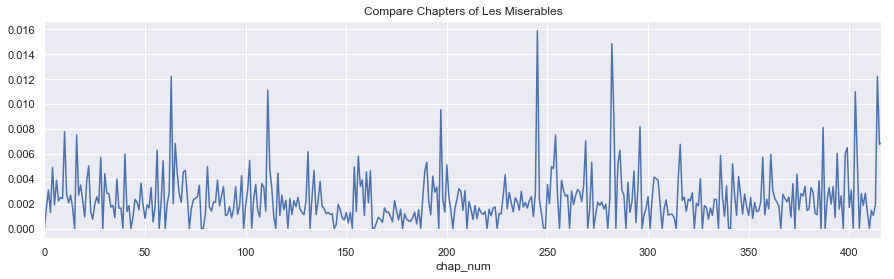

In [76]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of Les Miserables')

In [77]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [78]:
LM_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
LM_P.index.names = ['doc_x','doc_y']

In [79]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [80]:
LM_P['euclidean'] = 0
LM_P['euclidean'] = LM_P.apply(euclidean, 1)

In [81]:
LM_PME = LM_P.euclidean.unstack().fillna(0)

In [82]:
LM_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,407,408,409,410,411,412,413,414,415,416
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.709349,0.700723,0.722565,0.675640,0.689629,0.685199,0.700101,0.698741,0.696852,0.677630,...,0.684906,0.685404,0.697797,1.825061,0.695112,0.705357,0.688631,0.671081,0.678309,0.676923
1,0.000000,0.298898,0.377941,0.287066,0.328328,0.303826,0.326844,0.327639,0.324658,0.284320,...,0.311002,0.311666,0.341910,1.818702,0.333018,0.358335,0.324379,0.284107,0.297545,0.303412
2,0.000000,0.000000,0.348580,0.252890,0.297699,0.248181,0.288328,0.300038,0.287605,0.241609,...,0.284389,0.282112,0.319258,1.815222,0.309858,0.332585,0.296405,0.252507,0.267874,0.277422
3,0.000000,0.000000,0.000000,0.311657,0.359555,0.333704,0.347952,0.357445,0.353438,0.311668,...,0.335627,0.334783,0.363227,1.823588,0.355270,0.376400,0.343631,0.309010,0.320922,0.327700
4,0.000000,0.000000,0.000000,0.000000,0.261365,0.221075,0.250952,0.254528,0.249898,0.189098,...,0.224139,0.225418,0.266214,1.805702,0.254232,0.284220,0.240656,0.185408,0.203144,0.213058


In [83]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [84]:
LM_P['cosine'] = LM_P.apply(cosine, 1)
LM_PMC = LM_P.cosine.unstack().fillna(0)
LM_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,407,408,409,410,411,412,413,414,415,416
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.001297,0.000319,0.000158,0.001324,0.004609,0.001290,0.000280,0.000209,0.000265,0.000645,...,0.000496,0.000320,0.000694,9.080085e-02,0.000390,0.000820,0.001217,0.000986,0.000382,0.001747
1,0.000000,0.004463,0.001332,0.001296,0.002224,0.001722,0.002028,0.001614,0.001624,0.001559,...,0.000643,0.000593,0.000384,4.551417e-04,0.000568,0.000305,0.000514,0.000488,0.000458,0.000458
2,0.000000,0.000000,0.001957,0.001571,0.002535,0.003614,0.002963,0.001719,0.002474,0.002378,...,0.000609,0.000816,0.000236,9.291979e-07,0.000397,0.000594,0.000705,0.000615,0.000574,0.000342
3,0.000000,0.000000,0.000000,0.001201,0.001203,0.001027,0.001951,0.000764,0.000856,0.001233,...,0.000410,0.000506,0.000298,9.748744e-07,0.000429,0.000493,0.000731,0.000435,0.000452,0.000341
4,0.000000,0.000000,0.000000,0.000000,0.001238,0.001264,0.001620,0.001052,0.001089,0.001327,...,0.000632,0.000557,0.000310,5.354876e-04,0.000525,0.000485,0.000627,0.000459,0.000572,0.000473


## Cosine Similarity

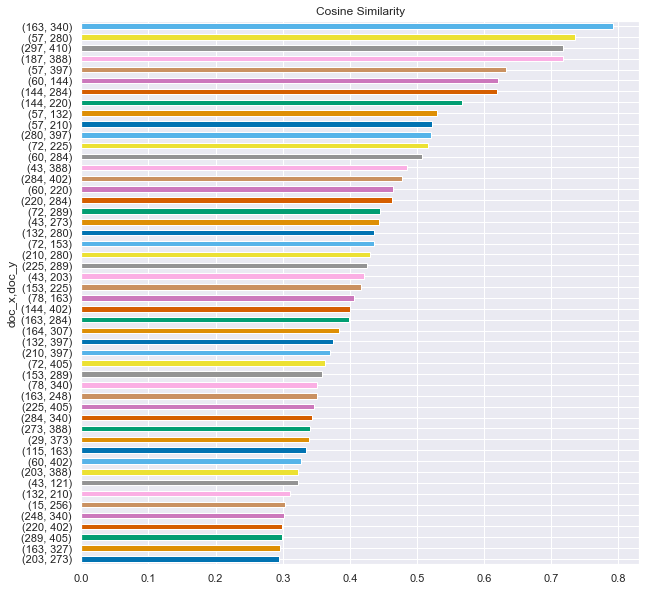

In [86]:
LM_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


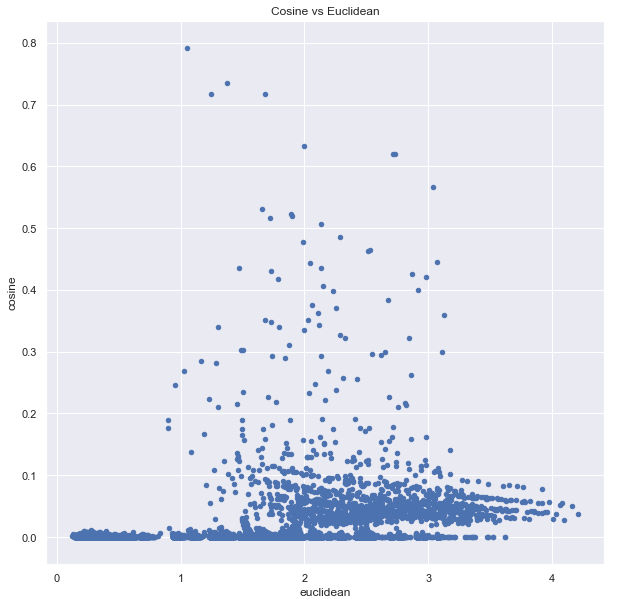

In [87]:
LM_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [88]:
import matplotlib.pyplot as plt

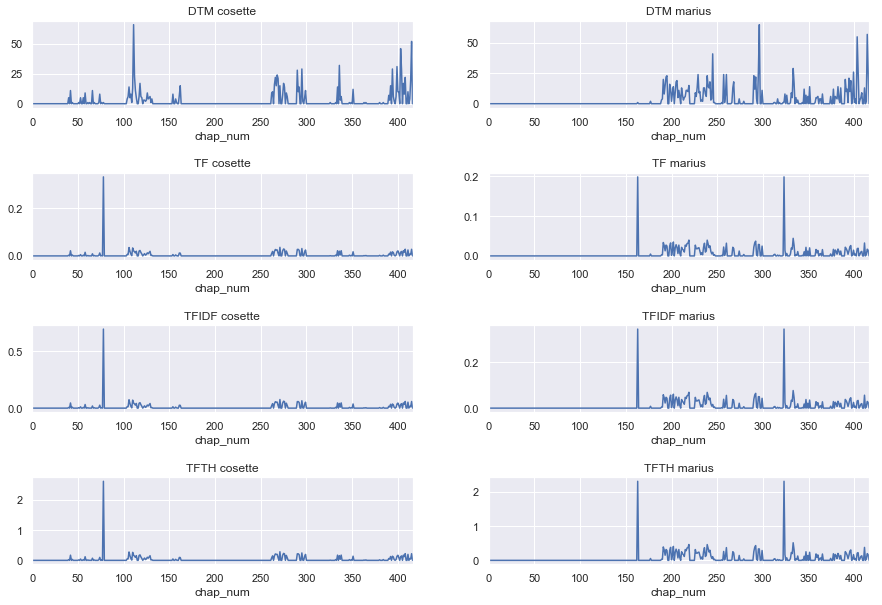

In [89]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('cosette marius'.split()):
    W = get_term_id(LM_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

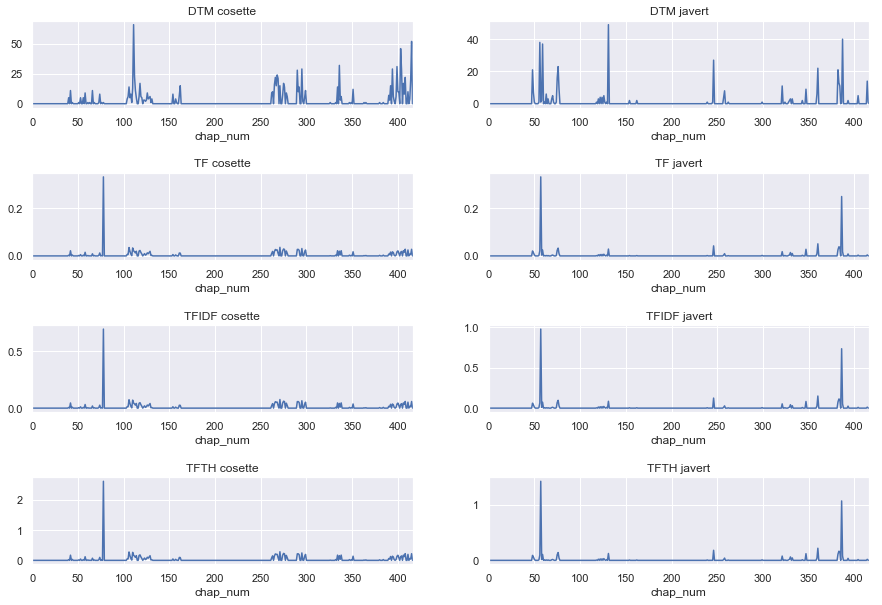

In [90]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('cosette javert'.split()):
    W = get_term_id(LM_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [91]:
LM_V.to_csv('Les_Misérables_V.csv', index=False)

## Visualize KDE Plots

In [92]:
LM_K.head()

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NNP      BOOK     0    0     book   
                           1          NNP     FIRST     0    0    first   
                           4           DT         A     0    0        a   
                           5          NNP      JUST     0    0     just   
                           6           NN       MAN     0    0      man   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0             2475  
                           1             8287  
                           4              131  
                           5            11560  
                           6            12703

In [103]:
lmk = LM_K.copy()

In [107]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                  
0        0        0        0             book     2475
                           1            first     8287
                           4                a      131
                           5             just    11560
                           6              man    12703

In [109]:
K = tt.reset_index()

In [110]:
K.rename_axis('offset', inplace=True)

In [118]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,book,first,a,just,man,chapter,i,m,myriel,in,m
term_id,2475,8287,131,11560,12703,3559,10386,12556,13737,10638,12556


In [115]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [116]:
V1 = LM_V[(LM_V[vocab_weight] > LM_V[vocab_weight].quantile(vocab_weight_quantile)) & (LM_V.n >= vocab_min_n)]

In [119]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,2475,7240,18574,18941,6958,8200,12824,8665,22229,11397
term_str,book,enlarge,seventh,sixth,eighth,fifth,marius,fourth,volume,javert
n,159,34,12,16,9,24,1355,34,23,459
p,0.000278821,5.9622e-05,2.10431e-05,2.80574e-05,1.57823e-05,4.20861e-05,0.00237611,5.9622e-05,4.03326e-05,0.000804897
port_stem,book,enlarg,seventh,sixth,eighth,fifth,mariu,fourth,volum,javert
stop,0,0,0,0,0,0,0,0,0,0
df,121,29,10,15,9,21,125,29,18,54
tf_sum,11.545,1.88763,1.24905,1.24465,1.06563,1.22266,2.28655,0.953292,0.799444,1.14961
tf_mean,0.0276858,0.0045267,0.00299533,0.00298476,0.00255548,0.00293204,0.00548333,0.00228607,0.00191713,0.00275685
tf_max,0.330804,0.398173,0.330804,0.330804,0.248574,0.330804,0.199087,0.248574,0.330804,0.330804
tfidf_sum,20.6083,7.2597,6.72237,5.97058,5.8972,5.27161,3.9743,3.66629,3.62466,3.39021


In [123]:
TOP_TERMS = LM_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [124]:
TOP_TERMS

['book',
 'enlarge',
 'seventh',
 'sixth',
 'eighth',
 'fifth',
 'marius',
 'fourth',
 'volume',
 'javert',
 'cosette',
 'third',
 'valjean',
 'ninth',
 'second',
 'jean',
 'grandson',
 'atom',
 'tenth',
 'twelfth',
 'parenthesis',
 'excellence',
 'leviathan',
 'derailed',
 'gavroche',
 'rue',
 'grandfather',
 'orion',
 'intestine',
 'desolations']

In [125]:
K = K[K.term_id.isin(V1.index)]

In [126]:
K.head(11).T

offset,0,1,4,8,14,16,22,23,27,28,30
term_str,book,first,man,myriel,myriel,bishop,old,man,five,years,age
term_id,2475,8287,12703,13737,13737,2230,14348,12703,8312,22839,559


In [127]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [128]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [130]:
B.head()

,offset,x
term_str,,
'll,"[44788, 63848, 118947, 130334, 155242, 161188,...","[[44788], [63848], [118947], [130334], [155242..."
'm,"[11991, 79109, 113328, 165424, 165937, 166949,...","[[11991], [79109], [113328], [165424], [165937..."
's,"[614, 964, 1489, 1536, 1659, 2501, 2563, 3234,...","[[614], [964], [1489], [1536], [1659], [2501],..."
abandoned,"[63777, 64289, 74356, 137336, 145347, 162459, ...","[[63777], [64289], [74356], [137336], [145347]..."
abbé,"[1112, 1224, 8570, 8580, 8586, 8700, 31039, 33...","[[1112], [1224], [8570], [8580], [8586], [8700..."


In [132]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [133]:
B.head()

,offset,x,kde,scores
term_str,,,,
'll,"[44788, 63848, 118947, 130334, 155242, 161188,...","[[44788], [63848], [118947], [130334], [155242...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-54.02133872327549, -53.00520437088851, -52.0..."
'm,"[11991, 79109, 113328, 165424, 165937, 166949,...","[[11991], [79109], [113328], [165424], [165937...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-16.693839979294793, -16.426564550871774, -16..."
's,"[614, 964, 1489, 1536, 1659, 2501, 2563, 3234,...","[[614], [964], [1489], [1536], [1659], [2501],...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-14.67383558685852, -14.586957241240544, -14...."
abandoned,"[63777, 64289, 74356, 137336, 145347, 162459, ...","[[63777], [64289], [74356], [137336], [145347]...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-94.28533715502213, -92.83313124234769, -91.3..."
abbé,"[1112, 1224, 8570, 8580, 8586, 8700, 31039, 33...","[[1112], [1224], [8570], [8580], [8586], [8700...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-11.754490879651836, -11.677078183814993, -11..."


In [134]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

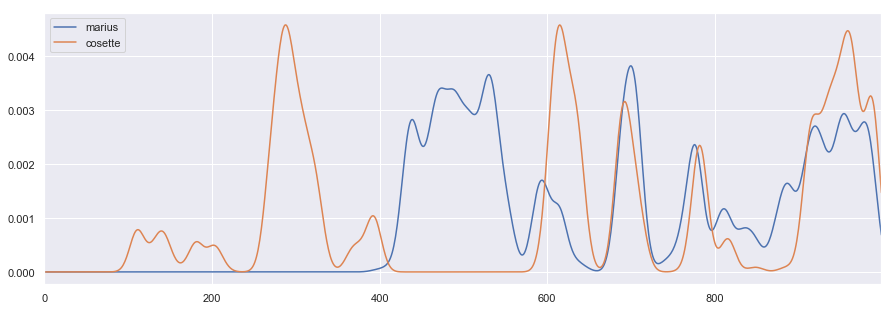

In [143]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['marius'].plot(**FIG)
PLOTS.loc['cosette'].plot(**FIG)
plt.legend(loc='upper left') 

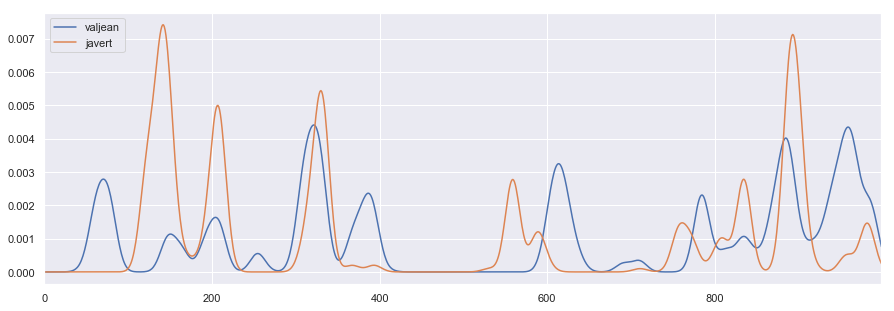

In [146]:
PLOTS.loc['valjean'].plot(**FIG)
PLOTS.loc['javert'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [161]:
WORDS = (LM_K.punc == 0) & (LM_K.num == 0) & LM_K.term_id.isin(LM_V[LM_V.stop==0].index)

In [163]:
BOW = LM_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [164]:
DTM = BOW.unstack().fillna(0)

In [165]:
alpha = .000001 
alpha_sum = alpha * LM_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [167]:
N_docs = DTM.shape[0]
LM_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / LM_V[LM_V.stop==0]['df'])

In [182]:
TFIDF.head()

term_id,0,1,2,3,4,5,6,7,8,9,...,22934,22935,22936,22937,22938,22939,22940,22941,22942,22943
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.879409e-06,2.111273e-06,2.548591e-06,2.879409e-06,2.879409e-06,2.879409e-06,2.548591e-06,2.879409e-06,2.879409e-06,2.879409e-06,...,2.548591e-06,2.355075e-06,2.879409e-06,2.879409e-06,2.879409e-06,2.879409e-06,2.879409e-06,2.879409e-06,2.548591e-06,2.879409e-06
1,1.787165e-08,1.310406e-08,1.581836e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.581836e-08,1.787165e-08,1.787165e-08,1.787165e-08,...,1.581836e-08,1.461726e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.787165e-08,1.581836e-08,1.787165e-08
2,1.016784e-08,7.455380e-09,8.999648e-09,1.016784e-08,1.016784e-08,1.016784e-08,8.999648e-09,1.016784e-08,1.016784e-08,1.016784e-08,...,8.999648e-09,8.316298e-09,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,1.016784e-08,8.999648e-09,1.016784e-08
3,2.417598e-08,1.772659e-08,2.139838e-08,2.417598e-08,2.417598e-08,2.417598e-08,2.139838e-08,2.417598e-08,2.417598e-08,2.417598e-08,...,2.139838e-08,1.977358e-08,2.417598e-08,2.417598e-08,2.417598e-08,2.417598e-08,2.417598e-08,2.417598e-08,2.139838e-08,2.417598e-08
4,6.413970e-09,4.702924e-09,5.677063e-09,6.413970e-09,6.413970e-09,6.413970e-09,5.677063e-09,6.413970e-09,6.413970e-09,6.413970e-09,...,5.677063e-09,5.246000e-09,6.413970e-09,6.413970e-09,6.413970e-09,6.413970e-09,6.413970e-09,6.413970e-09,5.677063e-09,6.413970e-09


## Principal Component Analysis

In [168]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [209]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,0.296368,0.134511
1,-0.061868,-0.017752
2,-0.062364,-0.017904
3,-0.062219,-0.017648
4,-0.060015,-0.016419
5,-0.052124,-0.016197
6,-0.060999,-0.016827
7,-0.062302,-0.017391
8,-0.061762,-0.017154
9,-0.062363,-0.017602


In [246]:
X = np.array(pca1)
X

array([[ 0.29636758,  0.13451075],
       [-0.06186831, -0.01775191],
       [-0.06236445, -0.01790443],
       [-0.06221858, -0.01764822],
       [-0.06001505, -0.01641917],
       [-0.05212352, -0.01619749],
       [-0.0609986 , -0.01682716],
       [-0.0623017 , -0.01739125],
       [-0.06176234, -0.01715375],
       [-0.06236322, -0.01760167],
       [-0.06178205, -0.01721533],
       [-0.06051747, -0.01667439],
       [-0.0609082 , -0.01811928],
       [-0.06114556, -0.01640251],
       [-0.06209506, -0.01756821],
       [ 0.32943901,  0.15886093],
       [-0.06214868, -0.01749494],
       [-0.05841944, -0.01609236],
       [-0.0627477 , -0.01780024],
       [-0.06168889, -0.01708578],
       [-0.06131858, -0.01931179],
       [-0.05672067, -0.01673581],
       [-0.0612257 , -0.01654565],
       [-0.0602183 , -0.01594093],
       [-0.06294025, -0.01836818],
       [-0.06220167, -0.017563  ],
       [-0.05993353, -0.01988998],
       [-0.06252448, -0.0190237 ],
       [-0.06155124,

In [247]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [248]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [249]:
print(pca.explained_variance_)

[0.03890736 0.02926744]


In [250]:
print(pca.mean_)

[-1.9968040e-18 -2.6457653e-18]


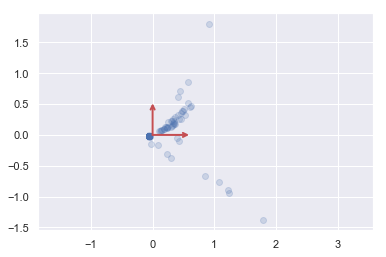

In [253]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [261]:
import sqlite3

In [257]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [268]:
text_db = 'db/Les_Misérables.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [269]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [270]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [271]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [272]:
emo_cols = combo.columns

In [273]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [274]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [275]:
tokens = tokens.join(combo, on='term_str', how='left')

In [276]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
399       43        43        86          NaN
198       1         4         42          NaN
409       1         0         90          NaN
189       3         16        1           NaN
135       1         0         8           NaN
283       12        0         8           NaN
282       236       0         24          NaN
89        25        13        10          NaN
336       10        0         15          NaN
160       86        0         3           NaN
Name: bing_sentiment, dtype: float64

In [277]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [278]:
tokens.head(10)

pos token_str  punc  num term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NNP      BOOK     0    0     book   
                           1          NNP     FIRST     0    0    first   
                           4           DT         A     0    0        a   
                           5          NNP      JUST     0    0     just   
                           6           NN       MAN     0    0      man   
1        0        0        0           NN   CHAPTER     0    0  chapter   
                           1          PRP         I     0    0        i   
                           4          NNP        M.     0    0        m   
                           5          NNP    MYRIEL     0    0   myriel   
         1        0        0           IN        In     0    0       in   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0             2382        0.0               0.0   
                           1             8163        0.0               0.0   
                           4                1        0.0               0.0   
                           5            11447        0.0               0.0   
                           6            12527        0.0               0.0   
1        0        0        0             3463        0.0               0.0   
                           1            10273        0.0               0.0   
                           4            12387        0.0               0.0   
                           5            13562        0.0               0.0   
         1        0        0            10524        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           4                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   
                           6                  0.0       0.0      0.0   
1        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           4                  0.0       0.0      0.0   
                           5                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           4                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   
                           6                   0.0           0.0          0.0   
1        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           4                   0.0           0.0          0.0   
                           5                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0            0.0   
                           4              

In [279]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

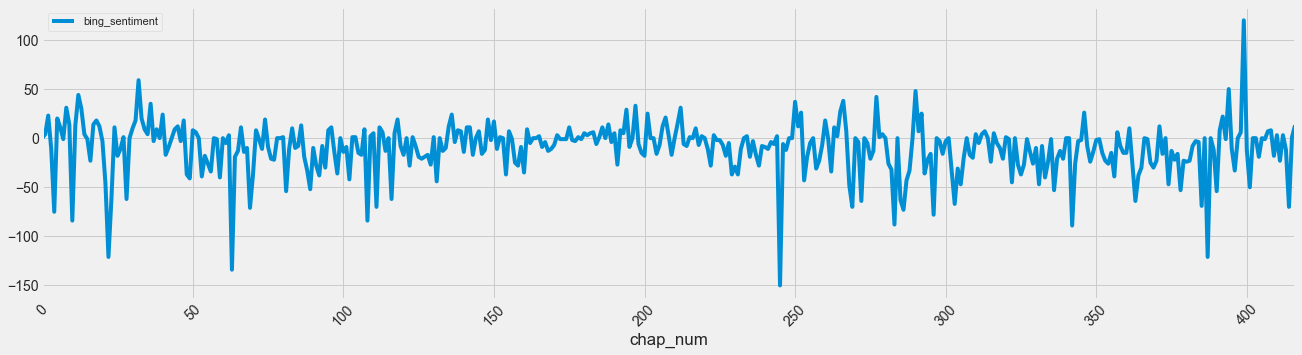

In [280]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [289]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [284]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [285]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0             <span class='sent0'>BOOK</span>
                              1            <span class='sent0'>FIRST</span>
                              4                <span class='sent0'>A</span>
                              5             <span class='sent0'>JUST</span>
                              6              <span class='sent0'>MAN</span>
Name: html, dtype: object

In [290]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [291]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,book first a just man,<span class='sent0'>BOOK</span> <span class='s...
1,chapter i m myriel in m charles françois bienv...,<span class='sent0'>CHAPTER</span> <span class...
2,chapter ii m myriel becomes m welcome the epis...,<span class='sent0'>CHAPTER</span> <span class...
3,chapter iii a hard bishopric for a good bishop...,<span class='sent0'>CHAPTER</span> <span class...
4,chapter iv works corresponding to words his co...,<span class='sent0'>CHAPTER</span> <span class...


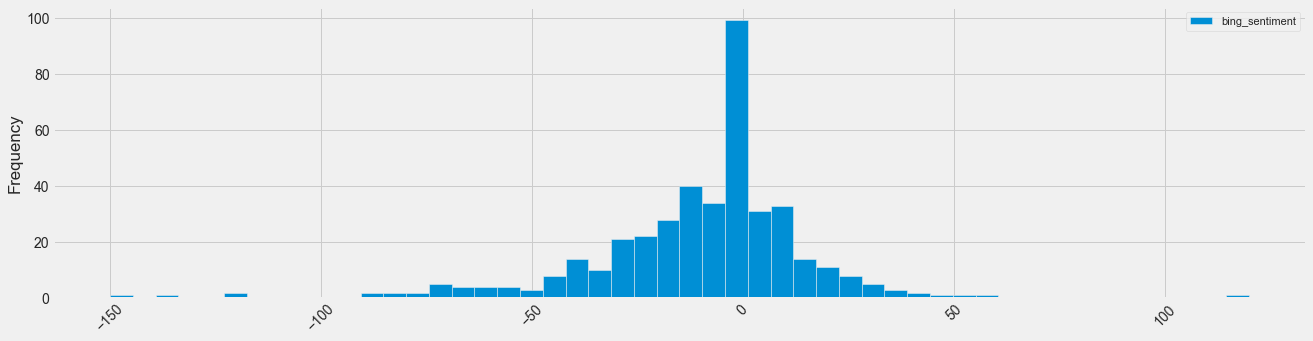

In [292]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [293]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
399,120.0,chapter ii jean valjean still wears his arm in...
32,59.0,chapter iii four and four it is hard nowadays ...
394,50.0,chapter vi the two old men do everything each ...
290,48.0,chapter i full light the reader has probably u...
12,44.0,chapter xii the solitude of monseigneur welcom...
277,42.0,chapter iv a heart beneath a stone enlarge the...
266,38.0,chapter v the rose perceives that it is an eng...
250,37.0,chapter i well cut and the two years which are...
36,35.0,chapter vii the wisdom of tholomyès in the mea...


### Negative

In [294]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
245,-150.0,chapter xx the trap the door of the garret had...
63,-134.0,chapter iii a tempest in a skull the reader ha...
22,-121.0,chapter vii the interior of despair let us try...
387,-121.0,chapter i javert passed slowly down the rue de...
342,-89.0,chapter i the charybdis of the faubourg saint ...
283,-88.0,chapter iii the vicissitudes of flight this is...
108,-84.0,chapter v the little one all alone as the thén...
10,-84.0,chapter x the bishop in the presence of an unk...
296,-78.0,chapter vii the old heart and the young heart ...


### Multinomial Emotions

In [295]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [296]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


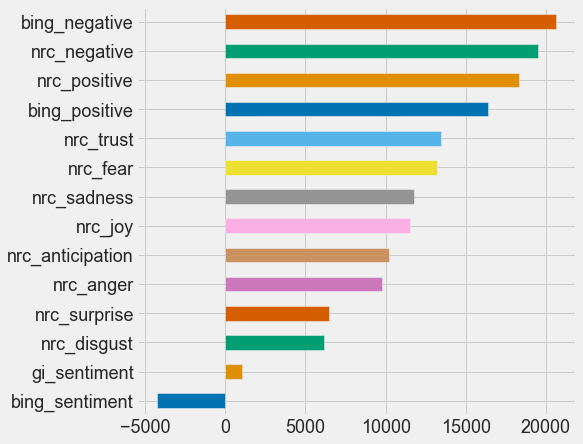

In [298]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [299]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [300]:
B.head()

,x
emo,
nrc_anger,"[[191], [239], [268], [376], [470], [635], [69..."
nrc_anticipation,"[[146], [194], [205], [239], [268], [295], [37..."
nrc_disgust,"[[376], [470], [834], [879], [978], [1361], [1..."
nrc_fear,"[[239], [268], [300], [325], [340], [374], [37..."
nrc_joy,"[[99], [194], [205], [217], [401], [450], [470..."


In [305]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

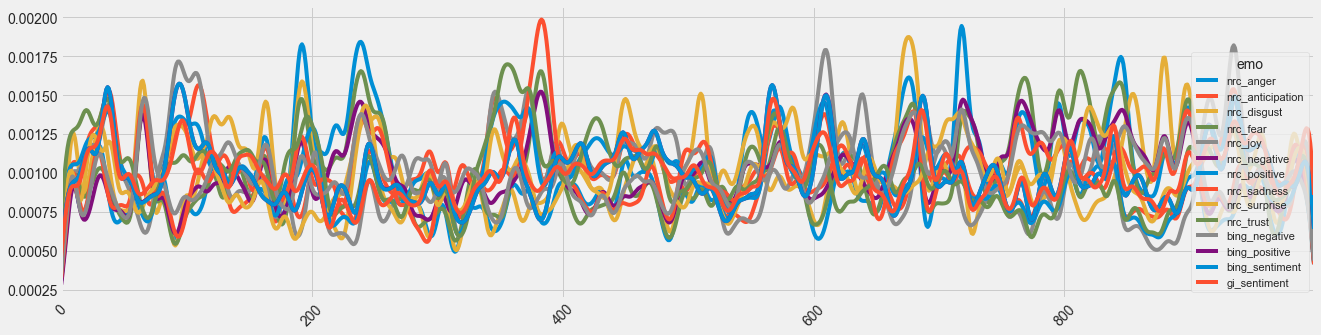

In [306]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

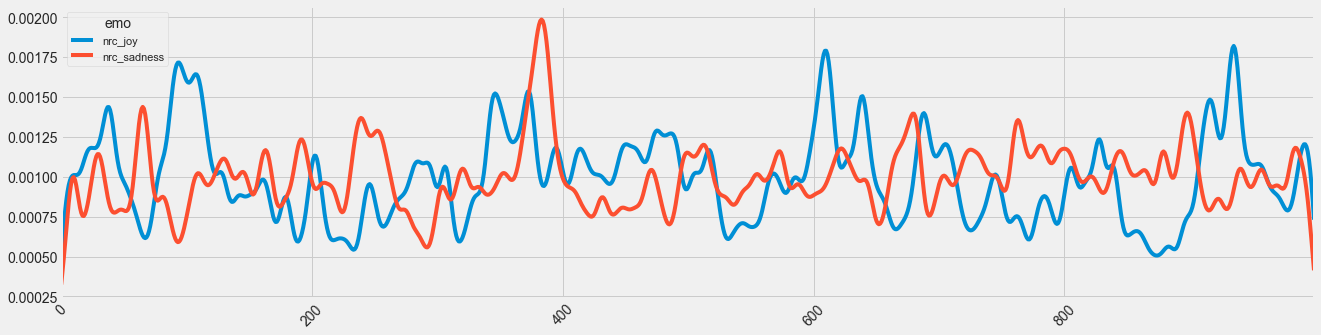

In [307]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

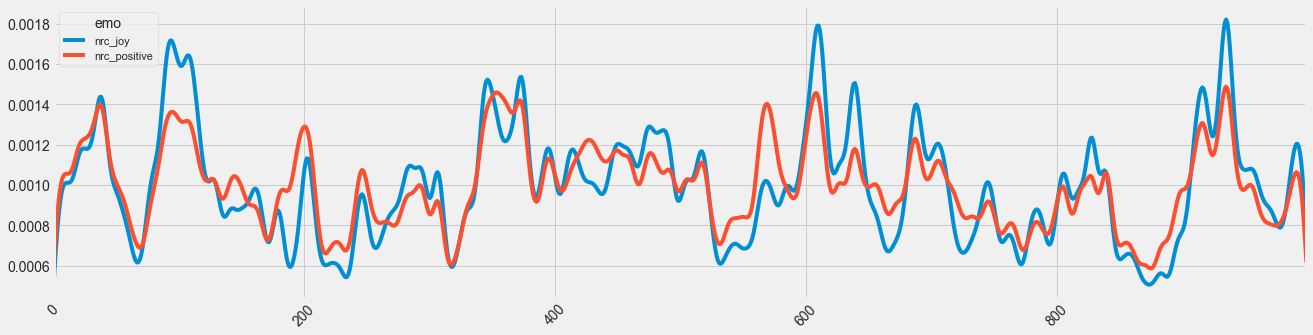

In [308]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

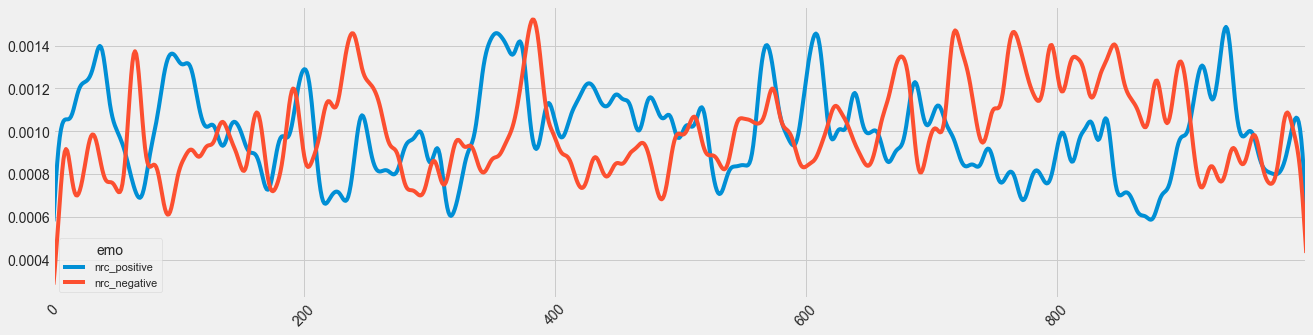

In [309]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

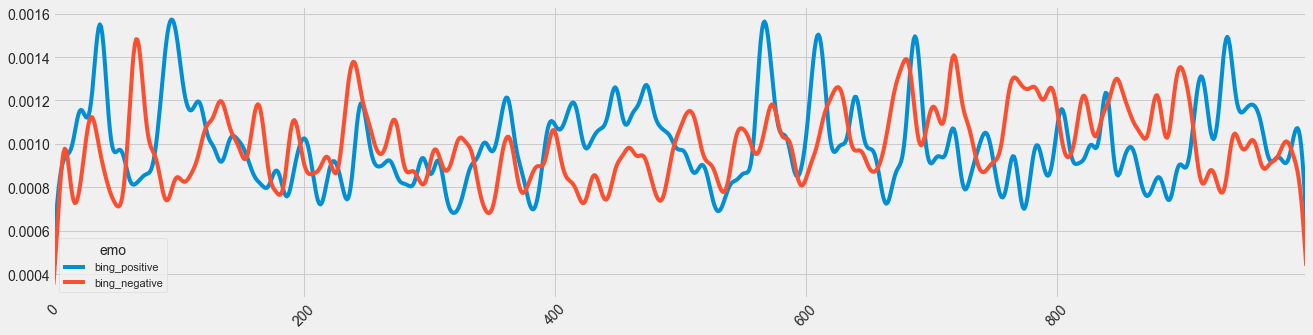

In [310]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)